In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [1]:
!pip install torch torchaudio transformers scikit-learn matplotlib


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/212 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/138 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.38k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/291 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/85.0 [00:00<?, ?B/s]

Toplam 27142 dosya bulundu.


pytorch_model.bin:   0%|          | 0.00/1.26G [00:00<?, ?B/s]

Some weights of HubertForSequenceClassification were not initialized from the model checkpoint at facebook/hubert-large-ls960-ft and are newly initialized: ['classifier.bias', 'classifier.weight', 'projector.bias', 'projector.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1, Training Loss: 0.6789975098690554
Validation Loss: 0.5275756755627045, Accuracy: 78.76%
Epoch 2, Training Loss: 0.5110709541167623
Validation Loss: 0.5142779858448215, Accuracy: 78.71%
Epoch 3, Training Loss: 0.4493075766205941
Validation Loss: 0.48080241560815273, Accuracy: 80.59%
Confusion Matrix:
[[1261  433   86]
 [  76 1628  119]
 [  28  312 1486]]
Accuracy: 0.81, Precision: 0.83, Recall (Sensitivity): 0.81, F1-Score: 0.81, Specificity: 0.83, AUC: 0.85


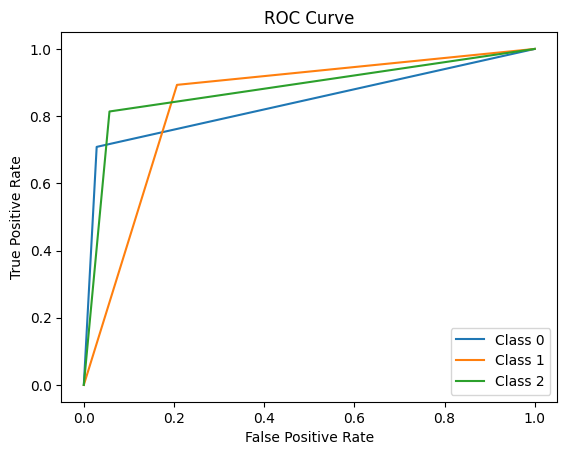

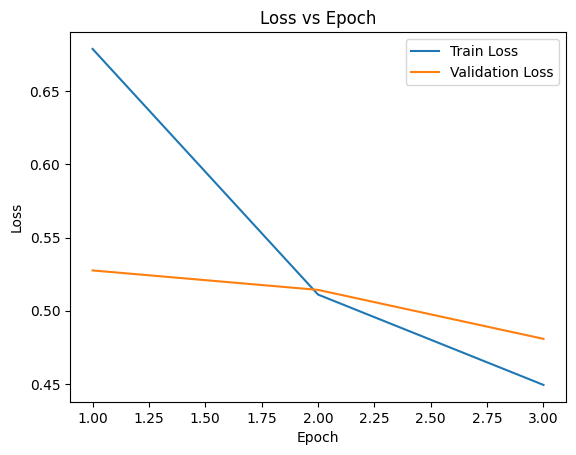

Training Time: 80902.38 seconds


In [3]:
from transformers import HubertForSequenceClassification, Wav2Vec2Processor
from torch.utils.data import DataLoader, Dataset
from torch.amp import GradScaler, autocast
from sklearn.metrics import (
    classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_score,
    recall_score, f1_score, accuracy_score
)
from sklearn.preprocessing import label_binarize
import torch
import glob
import numpy as np
import matplotlib.pyplot as plt
import torchaudio
import time

# Eğitim ve çıkarım zamanı hesaplama için timer
start_time = time.time()

# **1. Verilerin Hazırlanması**
class AudioDataset(Dataset):
    def __init__(self, audio_paths, labels):
        self.audio_paths = audio_paths
        self.labels = labels

    def __len__(self):
        return len(self.audio_paths)

    def __getitem__(self, idx):
        inputs = preprocess_audio(self.audio_paths[idx])
        label = torch.tensor(self.labels[idx], dtype=torch.long)
        return inputs, label

processor = Wav2Vec2Processor.from_pretrained("facebook/hubert-large-ls960-ft")
def preprocess_audio(audio_path, target_length=240000):  # 15 saniye = 16kHz * 15
    """
    Ham wav dosyasını okuyup yeniden örnekleme (16kHz) ve sabit uzunluk (15 saniye) işlemi yapar.
    """
    waveform, sample_rate = torchaudio.load(audio_path)
    if sample_rate != 16000:
        resampler = torchaudio.transforms.Resample(orig_freq=sample_rate, new_freq=16000)
        waveform = resampler(waveform)
    if waveform.size(1) > target_length:
        waveform = waveform[:, :target_length]
    elif waveform.size(1) < target_length:
        padding = target_length - waveform.size(1)
        waveform = torch.nn.functional.pad(waveform, (0, padding))
    inputs = processor(waveform.squeeze().numpy(), sampling_rate=16000, return_tensors="pt", padding=True)
    return inputs

# **2. Verilerin Tanımlanması**
folders = {
    "agresif": "/content/drive/MyDrive/Yazgel_Muzik/agresif/*.wav",
    "neseli": "/content/drive/MyDrive/Yazgel_Muzik/neseli/*.wav",
    "huzunlu": "/content/drive/MyDrive/Yazgel_Muzik/huzunlu/*.wav"
}

audio_paths = []
labels = []

# Sınıf etiketleri: agresif=0, neseli=1, huzunlu=2
for label, (class_name, path) in enumerate(folders.items()):
    files = glob.glob(path)
    audio_paths.extend(files)
    labels.extend([label] * len(files))

print(f"Toplam {len(audio_paths)} dosya bulundu.")

from sklearn.model_selection import train_test_split
train_paths, val_paths, train_labels, val_labels = train_test_split(audio_paths, labels, test_size=0.2, random_state=42)

train_dataset = AudioDataset(train_paths, train_labels)
val_dataset = AudioDataset(val_paths, val_labels)
train_loader = DataLoader(train_dataset, batch_size=4, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=4, shuffle=False)

# **3. Model, Optimizasyon ve Kayıp Fonksiyonu**
model = HubertForSequenceClassification.from_pretrained("facebook/hubert-large-ls960-ft", num_labels=3)
model.to("cuda")
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-5)
loss_fn = torch.nn.CrossEntropyLoss()
scaler = GradScaler()

# **4. Eğitim ve Validasyon**
train_losses = []
val_losses = []

for epoch in range(3):  # Daha fazla epoch ile performansı artırabilirsiniz
    model.train()
    total_loss = 0
    for batch in train_loader:
        inputs, labels = batch
        input_values = inputs["input_values"].mean(dim=1).to("cuda")
        attention_mask = inputs["attention_mask"][:, 0, :].to("cuda")
        labels = labels.to("cuda")

        with autocast(device_type="cuda"):
            outputs = model(input_values=input_values, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)

        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        total_loss += loss.item()
    train_losses.append(total_loss / len(train_loader))
    print(f"Epoch {epoch + 1}, Training Loss: {total_loss / len(train_loader)}")

    # Validasyon
    model.eval()
    val_loss = 0
    correct = 0
    true_labels = []
    predictions = []

    with torch.no_grad():
        for batch in val_loader:
            inputs, labels = batch
            input_values = inputs["input_values"].mean(dim=1).to("cuda")
            attention_mask = inputs["attention_mask"][:, 0, :].to("cuda")
            labels = labels.to("cuda")

            outputs = model(input_values=input_values, attention_mask=attention_mask)
            val_loss += loss_fn(outputs.logits, labels).item()
            preds = torch.argmax(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            true_labels.extend(labels.cpu().numpy())
            predictions.extend(preds.cpu().numpy())

    val_losses.append(val_loss / len(val_loader))
    print(f"Validation Loss: {val_loss / len(val_loader)}, Accuracy: {100 * correct / len(val_loader.dataset):.2f}%")

# **5. Performans Metrikleri**
conf_matrix = confusion_matrix(true_labels, predictions)
print(f"Confusion Matrix:\n{conf_matrix}")

accuracy = accuracy_score(true_labels, predictions)
precision = precision_score(true_labels, predictions, average='macro')
recall = recall_score(true_labels, predictions, average='macro')
f1 = f1_score(true_labels, predictions, average='macro')
specificity = np.mean([
    conf_matrix[i, i] / (np.sum(conf_matrix[:, i]) - conf_matrix[i, i] + conf_matrix[i, i])
    for i in range(3)
])
auc = roc_auc_score(label_binarize(true_labels, classes=[0, 1, 2]), label_binarize(predictions, classes=[0, 1, 2]), multi_class="ovr")

print(f"Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall (Sensitivity): {recall:.2f}, F1-Score: {f1:.2f}, Specificity: {specificity:.2f}, AUC: {auc:.2f}")

# **6. ROC Eğrisi ve Loss Grafiği**
for i in range(3):
    fpr, tpr, _ = roc_curve(label_binarize(true_labels, classes=[0, 1, 2])[:, i], label_binarize(predictions, classes=[0, 1, 2])[:, i])
    plt.plot(fpr, tpr, label=f"Class {i}")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.show()

plt.plot(range(1, len(train_losses) + 1), train_losses, label="Train Loss")
plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Loss vs Epoch")
plt.legend()
plt.show()

print(f"Training Time: {time.time() - start_time:.2f} seconds")
